In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os
import sys

CAUSICA_FOLDER = '/home/sandor_daniel/work/2024-05-07_active_bayesian_grn/Project-BayesDAG/src/'
RESULT_DIR = '/home/sandor_daniel/work/2024-05-07_active_bayesian_grn/results/'
ROOT_DIR = '/home/sandor_daniel/work/2024-05-07_active_bayesian_grn/'
sys.path.append(ROOT_DIR)
sys.path.append(CAUSICA_FOLDER)
from causica.models.bayesdag.bayesdag_nonlinear import BayesDAGNonLinear
from causica.datasets.variables import Variables, Variable
from causica.datasets.dataset import Dataset, CausalDataset

/home/sandor_daniel/miniconda3/envs/work/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic BayesDAG

In [2]:
def load_standard(file):
    standard = pd.read_csv(file, sep='\t', header=None)
    standard.replace([f'G{i}' for i in range(10)], [f'G0{i}' for i in range(10)], inplace=True)
    standard = standard.pivot(columns=[0], index=[1], values=[2])
    np.fill_diagonal(standard.values, 0)
    standard = standard.to_numpy()
    return standard

def remove_cycles_from_true_graph(true_graph):
    G = nx.from_numpy_array(true_graph, create_using=nx.DiGraph())
    for c in nx.simple_cycles(G):
        true_graph[c[0], c[1]] = 0
    return true_graph

timeseries = np.loadtxt(f'gnw_example/Example_dream4_timeseries.tsv', skiprows=1)[:,1:]
timeseries_split = np.split(timeseries, range(21,210,21), axis=0)

ground_truth =load_standard(f'gnw_example/Example_goldstandard.tsv')
ground_truth = remove_cycles_from_true_graph(ground_truth)
known_subgraph_mask = np.ones(ground_truth.shape)

train_data = np.vstack(timeseries_split[0:-2])
val_data = timeseries_split[-1]
test_data = timeseries_split[-2]

train_mask = np.ones(train_data.shape)
val_mask = np.ones(val_data.shape)
test_mask = np.ones(test_data.shape)

graph_args = {}
graph_args['num_variables'] = timeseries.shape[1]
graph_args['exp_edges'] = None
graph_args['exp_edges_per_node'] = None
graph_args['graph_type'] = None
graph_args['seed'] = 0

dataset = CausalDataset(train_data, 
                        train_mask, 
                        ground_truth, 
                        known_subgraph_mask, 
                        None, 
                        None, 
                        val_data=val_data,  
                        val_mask=val_mask,
                        test_data=test_data,
                        test_mask=test_mask,
                        graph_args=graph_args)

In [3]:
vars = Variables([Variable(f'G{i}', True, 'continuous', lower=0, upper=1)
         for i in range(1,timeseries.shape[1]+1)])
bd = BayesDAGNonLinear('Model1', vars, RESULT_DIR, 'cuda:0')

In [4]:
train_config_dict = {}
train_config_dict['batch_size'] = 4
train_config_dict['max_epochs'] = 10
# bd.run_train(dataset, train_config_dict)

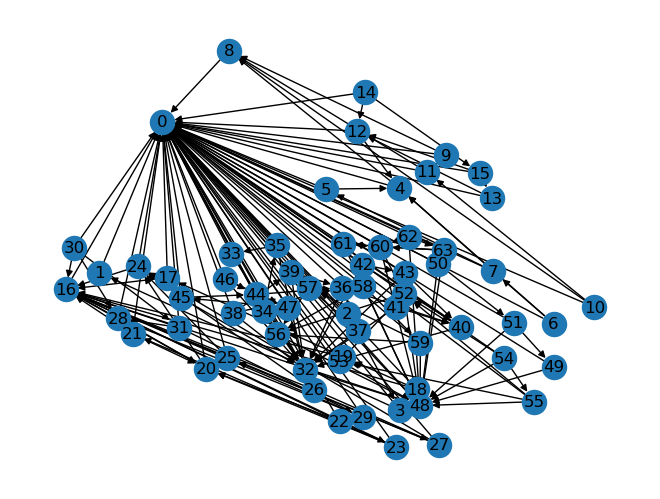

In [5]:
G = nx.from_numpy_array(ground_truth, create_using=nx.DiGraph())
nx.draw(G, with_labels=True)

## Active BayesDAG

In [6]:
from active_DAG_learning_framework import active_learning_procedure
from DAG_estimator import BayesDAGEstimator

def load_knockouts(file):
    ko = pd.read_csv(file, sep='\t', header=0)
    ko = ko.to_numpy()[:,1:]
    ko_dict = {i+1 : ko[i*21:(i+1)*21] for i in range(ko.shape[1])}
    return ko_dict

timeseries = np.loadtxt(f'gnw_example/Example_dream4_timeseries.tsv', skiprows=1)[:,1:]
train_data = timeseries[:-42]
val_data = timeseries[-21:]
test_data = timeseries[-42:-21]
ko_dict = load_knockouts('gnw_example/Example_knockout_timeseries.tsv')

# bd_estimator = BayesDAGEstimator('BayesDAGEstimator', vars, RESULT_DIR, 'cuda:0', graph_args)
# active_learning_procedure('uniform', val_data, test_data, ko_dict, train_data, bd_estimator)

In [7]:
from DAG_estimator import GFlowDAGEstimator

timeseries = np.loadtxt(f'gnw_example/Example_dream4_timeseries.tsv', skiprows=1)[:,1:]
train_data = pd.DataFrame(data=timeseries[:-42])
val_data =  pd.DataFrame(data=timeseries[-21:])
test_data =  pd.DataFrame(data=timeseries[-42:-21])



gflow_estimator = GFlowDAGEstimator('GFlowEstimator', vars, RESULT_DIR, 'cuda:0', graph_args)
active_learning_procedure('uniform', val_data, test_data, ko_dict, train_data, gflow_estimator)

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
/home/sandor_daniel/miniconda3/envs/work/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sandor_daniel/miniconda3/envs/work/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sandor_daniel/miniconda3/envs/work/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork(

8000
32


Training: 100%|██████████| 1001/1001 [01:14<00:00, 13.51it/s, epsilon=0.00, loss=1.62]
/home/sandor_daniel/miniconda3/envs/work/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/home/sandor_daniel/miniconda3/envs/work/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Training:   0%|          | 0/1 [00:00<?, ?it/s]


8
32


ValueError: Cannot take a larger sample than population when replace is False